In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import cv2 as cv
# use seaborn plotting defaults
import seaborn as sns; sns.set()
import numpy.random as nr

In [4]:
dataset = pd.read_csv('statefarm_data/driver_imgs_list.csv')
dataset.head(5)


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [10]:
dataset['classname'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

In [11]:
dataset.shape

(22424, 3)

In [5]:
N= 1000
reduced_sample = dataset.groupby('classname', group_keys=False)\
.apply(lambda x: x.sample(int(np.rint(N*len(x)/len(dataset))))).sample(frac=1).reset_index(drop=True)


In [17]:
reduced_sample

,subject,classname,img
0,p052,c3,img_18860.jpg
1,p041,c3,img_55189.jpg
2,p022,c1,img_47641.jpg
3,p024,c4,img_52427.jpg
4,p056,c1,img_40616.jpg
...,...,...,...
995,p061,c6,img_56760.jpg
996,p064,c0,img_66609.jpg
997,p049,c9,img_86713.jpg
998,p052,c6,img_76039.jpg


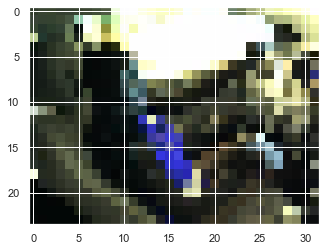

In [7]:
X = []
y = []
for index,row in reduced_sample.iterrows():
    img = cv.imread("statefarm_data/imgs/train/{}/{}".format(row['classname'],row['img']))
    img = cv.resize(img, (32, 24)) 
    X.append(img)
    y.append(row['classname'])
plt.imshow(X[3])
y = np.array(y)
X = np.array(X)

In [36]:
X.shape

(1000, 24, 32, 3)

In [8]:
X_ravel = X.reshape(X.shape[0], 32 * 24 * 3)

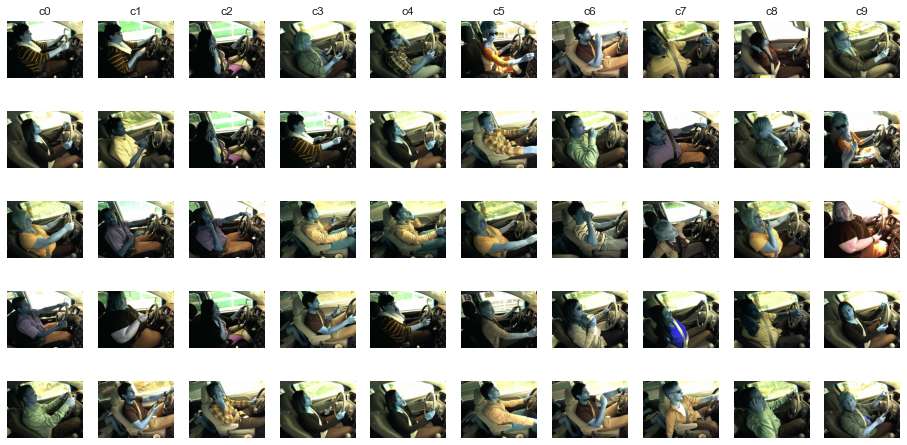

In [117]:
classes = np.unique(y)
num_classes = len(classes)
samples_per_class = 5
plt.figure(figsize=(16, 8)) 
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx],)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_ravel,y,random_state=42)

In [21]:
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf',)
model= make_pipeline(pca, svc)

In [22]:
model.fit(X_train,y_train)

Pipeline(steps=[('pca', PCA(n_components=150, random_state=42, whiten=True)),
                ('svc', SVC())])

In [24]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
### START CODE HERE ###
# Instantiate the grid search with the model and parameter grid
grid = GridSearchCV(model, param_grid)
# Train the grid of models. Time this process.
%time grid.fit(X_train,y_train)
# # Print the parameters which yield the best model performance
print("Best estimator found by grid search:")
print(grid.best_estimator_)

CPU times: user 1min 57s, sys: 1.36 s, total: 1min 58s
Wall time: 14.9 s
Best estimator found by grid search:
Pipeline(steps=[('pca', PCA(n_components=150, random_state=42, whiten=True)),
                ('svc', SVC(C=5, gamma=0.005))])


In [25]:
model = grid.best_estimator_
yfit = model.predict(X_test)


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yfit))

              precision    recall  f1-score   support

          c0       0.84      0.84      0.84        32
          c1       0.94      0.81      0.87        21
          c2       0.84      0.94      0.89        34
          c3       0.88      0.85      0.87        27
          c4       0.68      0.95      0.79        20
          c5       1.00      0.89      0.94        28
          c6       0.95      0.95      0.95        19
          c7       0.92      0.77      0.84        30
          c8       0.93      0.76      0.84        17
          c9       0.76      0.86      0.81        22

    accuracy                           0.86       250
   macro avg       0.87      0.86      0.86       250
weighted avg       0.88      0.86      0.87       250



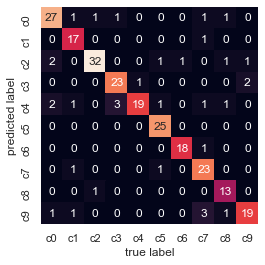

In [32]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('true label')
plt.ylabel('predicted label');

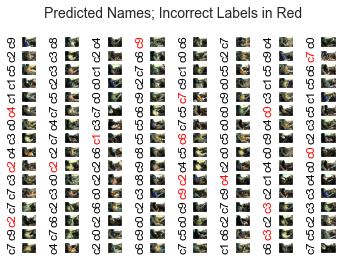

In [51]:
fig, ax = plt.subplots(16, 8)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(24, 32,3), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(yfit[i],color='black' if yfit[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);